In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR

In [2]:
# Set working directory and load the dataset
file_path = "C:\\Users\\HP\\OneDrive\\Desktop\\assignments\\pinksheet.xlsx"
df = pd.read_excel(file_path, sheet_name="Monthly Prices", skiprows=6)

In [3]:
# Rename the first column to "Date"
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

In [4]:
# Convert the Date column to Date format
df['Date'] = pd.to_datetime(df['Date'].astype(str) + '01', format='%Y%m%d')


ValueError: time data "1960M0101" doesn't match format "%Y%m%d", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [5]:
# Extract year and month from the Date column
df['Year'] = df['Date'].astype(str).str[:4]
df['Month'] = df['Date'].astype(str).str[5:]

In [6]:
# Create a new Date column with the first day of each month
df['Date'] = pd.to_datetime(df['Year'] + df['Month'] + '01', format='%Y%m%d')

In [7]:
# Drop the temporary Year and Month columns
df.drop(columns=['Year', 'Month'], inplace=True)


In [8]:
# Select specific columns (Date and selected commodities)
commodity = df.iloc[:, [0, 2, 24, 69, 71, 60, 30]]
commodity.columns = commodity.columns.str.lower()  # Clean column names

In [10]:
# Remove the Date column for analysis
commodity_data = commodity.drop(columns=['date'])

In [11]:
# Column names to test
columns_to_test = commodity_data.columns

In [12]:
# Initialize counters and lists for stationary and non-stationary columns
non_stationary_count = 0
stationary_columns = []
non_stationary_columns = []

In [13]:
# Loop through each column and perform the ADF test
for col in columns_to_test:
    adf_result = adfuller(commodity_data[col])
    p_value = adf_result[1]
    print(f"\nADF test result for column: {col}\n")
    print(f"Test Statistic: {adf_result[0]}")
    print(f"P-value: {p_value}")


ADF test result for column: crude_brent

Test Statistic: -1.507866191093539
P-value: 0.5296165197702375

ADF test result for column: soybeans

Test Statistic: -2.4231464527418907
P-value: 0.1353097742779037

ADF test result for column: gold

Test Statistic: 1.3430517021932997
P-value: 0.9968394353612381

ADF test result for column: silver

Test Statistic: -1.3972947107462228
P-value: 0.5835723787985759

ADF test result for column: urea_ee_bulk

Test Statistic: -2.510171631520914
P-value: 0.11301903181624517

ADF test result for column: maize

Test Statistic: -2.470045106092041
P-value: 0.12293380919376795


In [30]:
 if p_value > 0.05:
non_stationary_count += 1
non_stationary_columns.append(col)
else:
stationary_columns.append(col)

IndentationError: expected an indented block after 'if' statement on line 1 (3014917300.py, line 2)

In [31]:
# Print the number of non-stationary columns and the lists of stationary and non-stationary columns
print(f"\nNumber of non-stationary columns: {non_stationary_count}\n")
print(f"Non-stationary columns: {non_stationary_columns}\n")
print(f"Stationary columns: {stationary_columns}")


Number of non-stationary columns: 0

Non-stationary columns: []

Stationary columns: []


In [17]:
# Co-Integration Test (Johansen's Test)
lags = VAR(commodity_data).select_order(maxlags=10)
lag_length = lags.aic

In [18]:
johansen_test = coint_johansen(commodity_data, det_order=0, k_ar_diff=lag_length)

In [19]:
# Summary of the Co-Integration Test
print("\nJohansen Test Results:\n")
print(johansen_test.lr1)  # Trace statistic
print(johansen_test.cvt)  # Critical values


Johansen Test Results:

[176.46252708 104.96585715  67.84627098  37.39727549  16.60719811
   5.3013434 ]
[[ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


In [20]:
# Determine the number of co-integrating relationships (r) based on the test
r = sum(johansen_test.lr1 > johansen_test.cvt[:, 1])  # Assume 5% significance level
print(f"Number of co-integrating relationships: {r}")

Number of co-integrating relationships: 6


In [21]:
if r > 0:
    # If co-integration exists, estimate the VECM model
    vecm_model = VECM(commodity_data, k_ar_diff=lag_length, coint_rank=r, deterministic='co')
    vecm_fit = vecm_model.fit()

In [22]:
# Summary of the VECM model
    print("\nVECM Model Summary:\n")
    print(vecm_fit.summary())

IndentationError: unexpected indent (1435165675.py, line 2)

In [25]:
# Summary of the VECM model
print("\nVECM Model Summary:\n")
print(vecm_fit.summary())



VECM Model Summary:

Det. terms outside the coint. relation & lagged endog. parameters for equation crude_brent
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5111      0.472     -1.083      0.279      -1.436       0.414
L1.crude_brent      0.3290      0.038      8.553      0.000       0.254       0.404
L1.soybeans         0.0065      0.008      0.828      0.408      -0.009       0.022
L1.gold             0.0005      0.006      0.071      0.944      -0.012       0.013
L1.silver          -0.0883      0.162     -0.546      0.585      -0.405       0.229
L1.urea_ee_bulk    -0.0059      0.005     -1.211      0.226      -0.015       0.004
L1.maize            0.0210      0.017      1.212      0.226      -0.013       0.055
L2.crude_brent     -0.0366      0.041     -0.901      0.368      -0.116       0.043
L2.soybeans         0.0136      0.008      1.77

In [27]:
 # Extracting the coefficients from the VECM model
vecm_coefs = vecm_fit.params
print("\nVECM Coefficients:\n")
print(vecm_coefs)

AttributeError: 'VECMResults' object has no attribute 'params'

In [32]:
# Extracting the adjustment coefficients (alpha) and cointegration vectors (beta) from the VECM model
alpha = vecm_fit.alpha
beta = vecm_fit.beta
print("\nAdjustment Coefficients (Alpha):\n")
print(alpha)
print("\nCointegration Vectors (Beta):\n")
print(beta)


Adjustment Coefficients (Alpha):

[[-4.23269426e-02  2.68119012e-03 -2.07692237e-04  1.18220251e-01
  -1.37133079e-03  3.91015997e-03]
 [-5.00668375e-02 -1.13541350e-01  8.24526323e-03  4.35607886e-01
   3.15074626e-02  7.80770788e-02]
 [ 1.53373817e-01  9.84868471e-03  1.32164321e-02 -8.99804119e-01
   7.23330210e-03 -8.15713238e-02]
 [ 5.86659095e-03  2.31072108e-03  5.68315684e-04 -6.45968876e-02
  -1.12604932e-03 -3.00254675e-03]
 [ 9.79771904e-02  1.08322435e-01  3.62924070e-03 -1.23589345e-01
  -1.35921427e-01 -5.60628170e-02]
 [-3.95166966e-02  4.42677281e-03  1.40820254e-03  4.22919792e-01
   2.00963527e-02 -9.75308618e-02]]

Cointegration Vectors (Beta):

[[ 1.00000000e+00  1.29715054e-17  1.42125404e-15  1.82410200e-17
  -2.76544047e-16 -3.57896382e-16]
 [-3.61962455e-17  1.00000000e+00  3.97790224e-15 -1.84816475e-17
   1.03117965e-15  3.60046699e-16]
 [ 5.02980436e-18  3.05547233e-17  1.00000000e+00  3.40139401e-18
  -9.68005186e-17 -3.56744071e-17]
 [ 1.04378966e-16 -1.08

In [33]:
# Forecasting using the VECM model
forecast = vecm_fit.predict(steps=24)

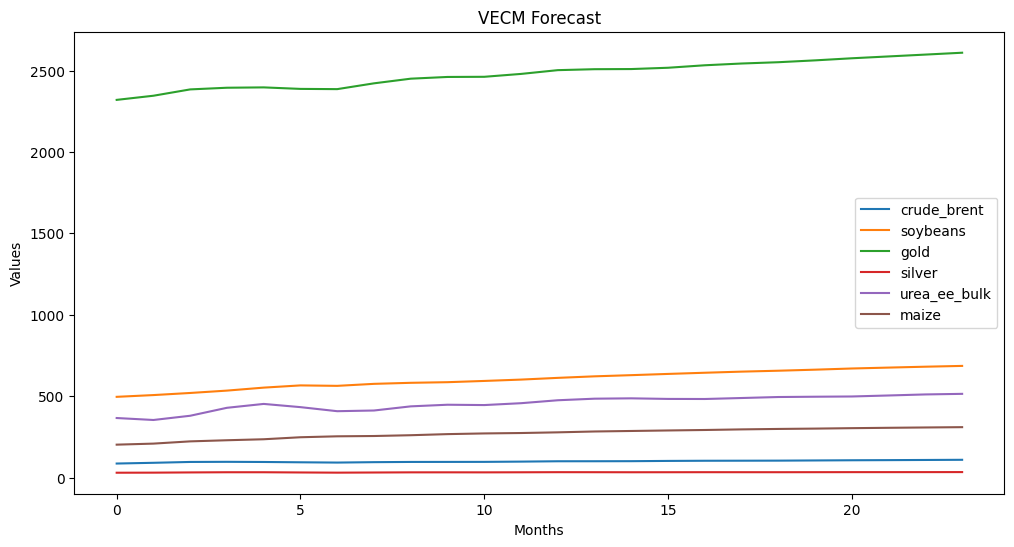

In [36]:
# Plotting the forecast
plt.figure(figsize=(12, 6))
for i, col in enumerate(commodity_data.columns):
    plt.plot(forecast[:, i], label=col)
plt.title('VECM Forecast')
plt.xlabel('Months')
plt.ylabel('Values')
plt.legend()
plt.show()


In [41]:

# If no co-integration exists, proceed with Unrestricted VAR Analysis
var_model = VAR(commodity_data)
var_fit = var_model.fit(lag_length)

In [42]:
# Summary of the VAR model
print("\nVAR Model Summary:\n")
print(var_fit.summary())


VAR Model Summary:

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Jul, 2024
Time:                     01:36:21
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    27.2744
Nobs:                     765.000    HQIC:                   26.0434
Log likelihood:          -15849.8    FPE:                9.47417e+10
AIC:                      25.2729    Det(Omega_mle):     6.24636e+10
--------------------------------------------------------------------
Results for equation crude_brent
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.567481         0.483126           -1.175           0.240
L1.crude_brent          1.292999         0.039591           32.659           0.000
L1.soybeans             0

In [44]:
# Forecasting using the VAR model
forecast = var_fit.forecast(var_fit.endog, steps=24)

In [45]:
# Plotting the forecast
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(commodity_data.columns):
        plt.plot(forecast[:, i], label=col)
    plt.title('VAR Forecast')
    plt.xlabel('Months')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

IndentationError: unexpected indent (1668798549.py, line 2)

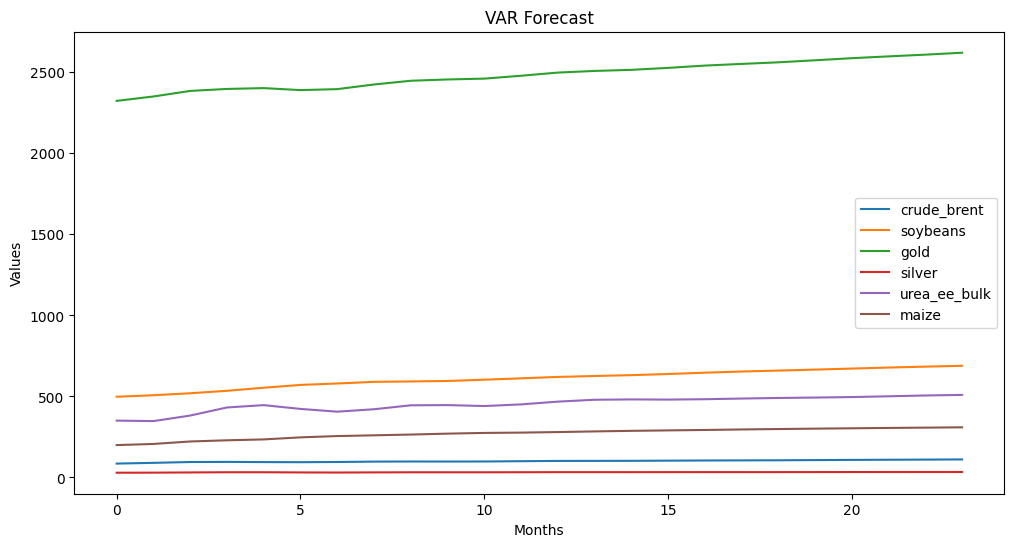

In [46]:
# Plotting the forecast
plt.figure(figsize=(12, 6))
for i, col in enumerate(commodity_data.columns):
    plt.plot(forecast[:, i], label=col)
plt.title('VAR Forecast')
plt.xlabel('Months')
plt.ylabel('Values')
plt.legend()
plt.show()
